In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, confusion_matrix,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from dp_ss_functions import *

### Data loading and prep

In [4]:
df = pd.read_csv('data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1000 non-null   int64  
 1   created_date                  1000 non-null   object 
 2   business_type                 837 non-null    object 
 3   postcode                      1000 non-null   object 
 4   employee_count                1000 non-null   int64  
 5   has_north_american_customers  1000 non-null   bool   
 6   segment                       1000 non-null   object 
 7   utm_medium                    882 non-null    object 
 8   net_premium                   1000 non-null   float64
 9   commission                    1000 non-null   float64
 10  sale                          1000 non-null   int64  
 11  email_domain                  1000 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(6)
memory usage: 87.0+

Text(0.5, 1.0, 'SuperScript, Quotes by attributed utm_medium')

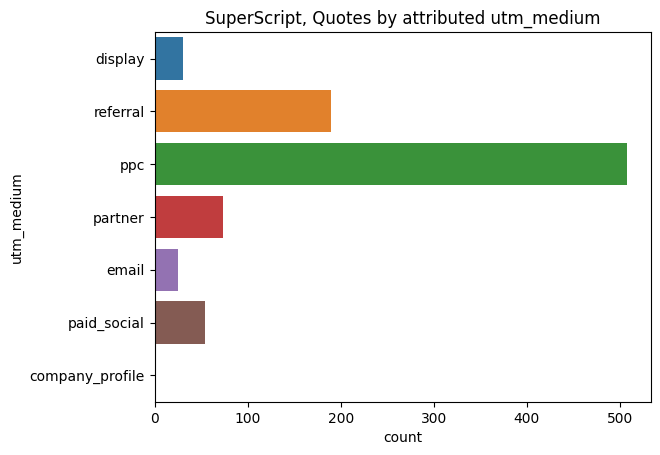

In [6]:
sns.countplot(data=df,y="utm_medium")
plt.title('SuperScript, Quotes by attributed utm_medium')

In [7]:
df.loc[df['utm_medium'].isnull(),'utm_medium'] = 'Direct'

Text(0.5, 1.0, 'SuperScript, Quotes by attributed utm_medium')

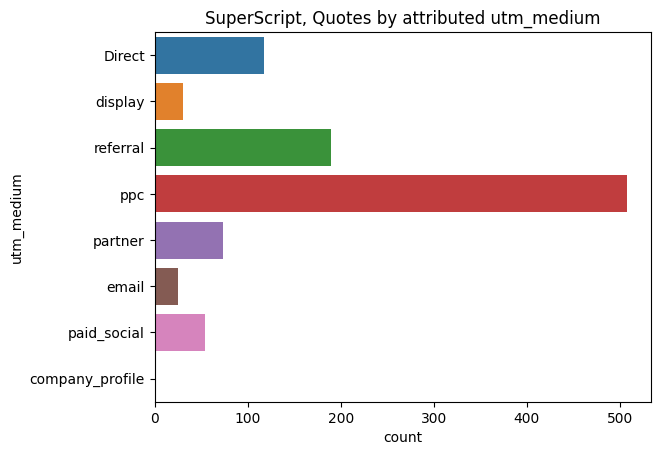

In [8]:
sns.countplot(data=df,y="utm_medium")
plt.title('SuperScript, Quotes by attributed utm_medium')

In [9]:
df['business_type'].isnull().value_counts()

False    837
True     163
Name: business_type, dtype: int64

In [10]:
df[df['business_type'].isnull()]['segment'].value_counts()

Landlord    163
Name: segment, dtype: int64

In [14]:
df.loc[df['business_type'].isnull(),'business_type'] = 'not_applicable'
df['created_date'] = pd.to_datetime(df['created_date'])
df['created_dow']=df['created_date'].dt.strftime('%A')
df['postcode_area']=df['postcode'].apply(get_characters_until_first_number)
df['commission_rate'] = df['commission']/df['net_premium']

#### Part 1
**Conversion Analysis**: Analyse how the conversion rate (sales divided by opportunities to make a sale (quotes)) is affected by key factors such as business type, segment, employee count, and price.

Text(0.5, 1.0, 'SuperScript, Conversion rate by Business Type')

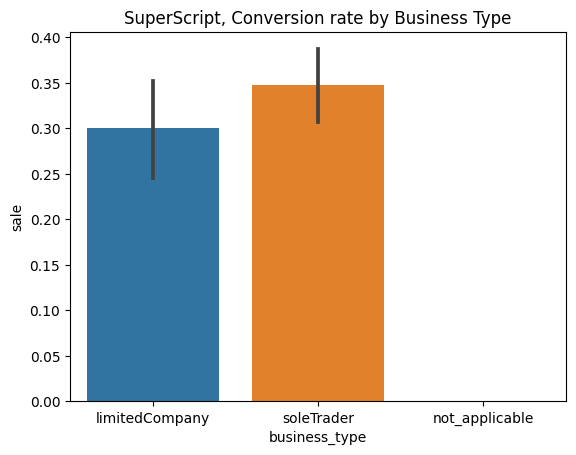

In [15]:
sns.barplot(data=df,x="business_type",y="sale")
plt.title("SuperScript, Conversion rate by Business Type")

Text(0.5, 1.0, 'HDI (95%), Conversion rate limitedCompany vs soleTrader')

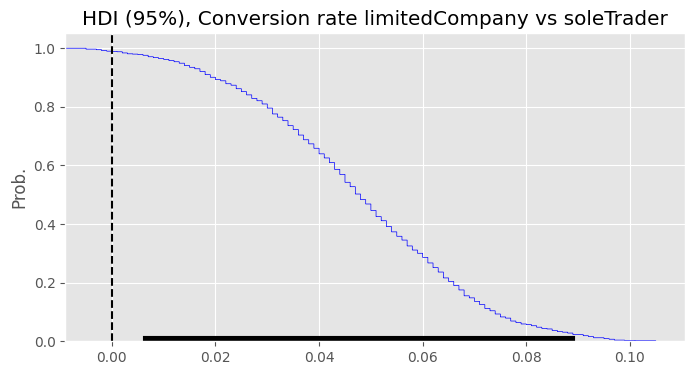

In [16]:
limited = df[df['business_type']=='limitedCompany']['sale']
sole = df[df['business_type']=='soleTrader']['sale']
diffs = diff_calculation(sole,limited)
hdi_plot(diffs)
plt.title('HDI (95%), Conversion rate limitedCompany vs soleTrader')

Text(0.5, 1.0, 'SuperScript, Convertion by Segment')

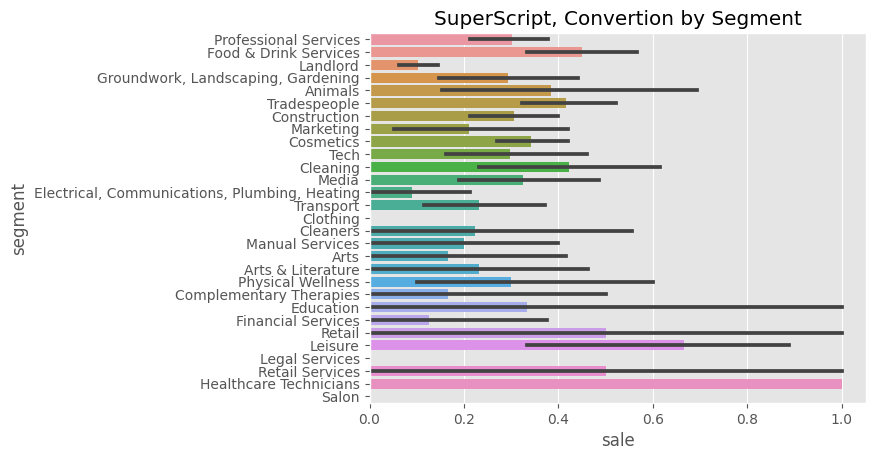

In [17]:
sns.barplot(data=df,x="sale",y="segment",orient="h")
plt.title("SuperScript, Convertion by Segment")

<AxesSubplot:xlabel='employee_count', ylabel='Count'>

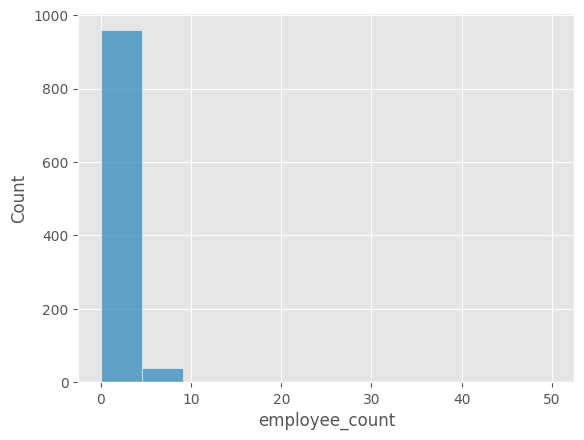

In [18]:
sns.histplot(data=df,x="employee_count")

In [19]:
df['employees_group'] = pd.cut(df['employee_count'],bins=[-1,0,1,10,100],labels=['no_employees','one_employee','up_to_10','more_than_10'])

Text(0.5, 1.0, 'SuperScript, Conversion rate by number of employees')

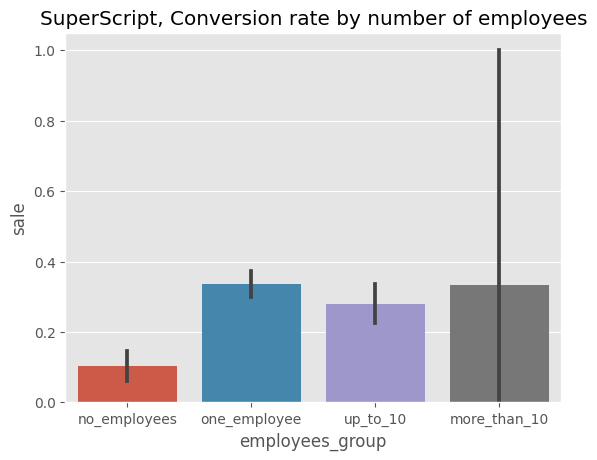

In [20]:
sns.barplot(data=df,x="employees_group",y="sale")
plt.title('SuperScript, Conversion rate by number of employees')

Text(0.5, 1.0, 'SuperScript, Distribution of price sale (blue) vs no-sale (red)')

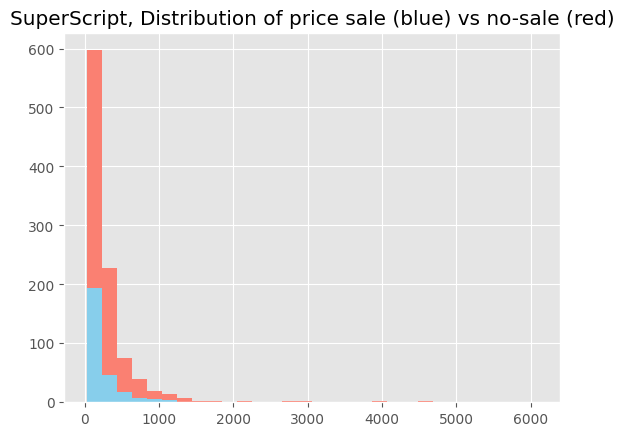

In [21]:
df['total_premium_no_tax'] = df['net_premium'] + df['commission']
sale = df[df['sale']==1]['total_premium_no_tax']
no_sale = df[df['sale']==0]['total_premium_no_tax']
plt.hist([sale,no_sale],stacked=True,color=['skyblue', 'salmon'],label=['Sale','No Sale'],bins=30)
plt.title('SuperScript, Distribution of price sale (blue) vs no-sale (red)')

### Part 2

**Optimal Commission Modeling**: Use machine learning techniques to model the relationship between commission and conversion. Suggest the optimal commission for each customer that balances conversion and revenue (the commission is Superscript's revenue, so dropping the commission to 0% to reduce the end price may result in better conversion, but would be very harmful to our revenue), while maintaining the 40% average commission.

In [22]:
df.head()

,id,created_date,business_type,postcode,employee_count,has_north_american_customers,segment,utm_medium,net_premium,commission,sale,email_domain,created_dow,postcode_area,commission_rate,employees_group,total_premium_no_tax
0,51983,2023-05-09,limitedCompany,G5 2TX,3,False,Professional Services,Direct,57.12,27.48,1,hotmail.com,Tuesday,G5,0.481092,up_to_10,84.60
1,88200,2023-05-15,soleTrader,E39 6YD,1,False,Food & Drink Services,display,55.32,36.84,0,icloud.com,Monday,E3,0.665944,one_employee,92.16
2,67116,2023-05-21,not_applicable,SL7 4TF,0,False,Landlord,referral,281.40,46.80,0,gmail.com,Sunday,SL7,0.166311,no_employees,328.20
3,19694,2023-05-19,limitedCompany,DA75 4YX,3,False,"Groundwork, Landscaping, Gardening",ppc,77.88,51.96,0,outlook.com,Friday,DA7,0.667180,up_to_10,129.84
4,97476,2023-05-21,soleTrader,NW84 6LR,1,False,Animals,partner,63.96,21.36,1,gmail.com,Sunday,NW8,0.333959,one_employee,85.32


In [23]:
model_data = df[['sale','commission_rate','business_type','postcode_area','employees_group','created_dow','has_north_american_customers','segment','utm_medium','net_premium','email_domain']]
model_data = one_hot_encode(model_data)

In [24]:
X = model_data.drop(columns=['sale'])
y = model_data['sale']
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=12)
mean_accuracy_rf = kfold_cross_validation(X.values, y.values, rf_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.725
Mean Precision: 0.6809342463846095
Mean Recall: 0.725
Mean F1 Score: 0.666039522390987
Mean AUC Score: 0.710769898048658
Mean Log Loss: 0.5305675762958403


In [26]:
xgb_model = XGBClassifier(eval_metric='mlogloss')
mean_accuracy_xgb = kfold_cross_validation(X.values, y.values, xgb_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.6950000000000001
Mean Precision: 0.6772177534562502
Mean Recall: 0.6950000000000001
Mean F1 Score: 0.6834524745122887
Mean AUC Score: 0.6786384678586712
Mean Log Loss: 0.7265512996630166


In [27]:
svm_model = SVC(probability=True)
mean_accuracy_svm = kfold_cross_validation(X.values, y.values, svm_model, n_splits=5,threshold=0.5)

Mean Accuracy: 0.7210000000000001
Mean Precision: 0.5217352010050252
Mean Recall: 0.7210000000000001
Mean F1 Score: 0.6052083547373384
Mean AUC Score: 0.5007672565105262
Mean Log Loss: 0.5922212590951081


In [28]:
LGBM_model = LGBMClassifier()
mean_accuracy_LGBM = kfold_cross_validation(X.values, y.values, LGBM_model, n_splits=5,threshold=0.5)

[LightGBM] [Info] Number of positive: 221, number of negative: 579
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 589
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.276250 -> initscore=-0.963140
[LightGBM] [Info] Start training from score -0.963140
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Text(0.5, 1.0, 'SS, Conversion Model Feature Importance')

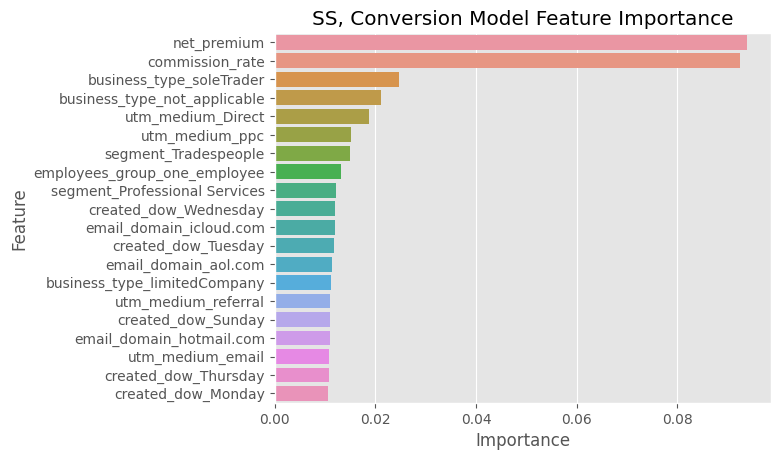

In [29]:
feature_importances = rf_model.feature_importances_

feature_importance_df= pd.DataFrame({
    'Feature': X_train.columns,  # If X is a DataFrame
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(data=feature_importance_df.head(20),x='Importance',y='Feature')
plt.title('SS, Conversion Model Feature Importance')

### Optimisation

In [30]:
X = model_data.drop(columns=['sale'])

In [31]:
import numpy as np

# Predict conversion rate using the trained RandomForestClassifier
def predict_conversion_rate(commission, customer_features):
    feature_set = np.column_stack([commission, customer_features])
    probabilities = rf_model.predict_proba(feature_set)
    return probabilities[:, 1]

# Calculate revenue based on predicted conversion rate and commission
def revenue(commission, customer_features, prices):
    total_revenue = 0
    for i in range(len(customer_features)):
        conv_rate = predict_conversion_rate(commission[i], customer_features.iloc[[i]])
        total_revenue += conv_rate * prices.iloc[i] * commission[i]
    return total_revenue

# Define the random search optimisation with tolerance for the average commission
def random_search(customer_features, prices, n_iter=1000, avg_commission_target=0.40, tolerance=0.01):
    best_commissions = None
    best_revenue = -np.inf  # Initialize with negative infinity to track the best revenue

    for _ in range(n_iter):
        # Generate random commission rates for all customers between 0 and 1
        random_commissions = np.random.uniform(0, 1, len(customer_features))
        
        # Check if the average commission constraint is satisfied with tolerance
        avg_commission = np.mean(random_commissions)
        if avg_commission_target - tolerance <= avg_commission <= avg_commission_target + tolerance:
            # Evaluate total revenue with this set of commission rates
            current_revenue = revenue(random_commissions, customer_features, prices)
            
            # Step 4: Update the best solution if current revenue is better
            if current_revenue > best_revenue:
                best_revenue = current_revenue
                best_commissions = random_commissions
    
    return best_commissions, best_revenue

# Example of running the random search

prices = X['net_premium']
customer_features = X.drop(columns='commission_rate')

best_commissions, best_revenue = random_search(customer_features, prices, n_iter=1000, tolerance=0.075)

print("Best Commissions:", best_commissions)
print("Best Revenue:", best_revenue)

Best Commissions: [5.99089331e-01 3.34653538e-02 4.94297447e-01 1.42825667e-01
 2.35534044e-01 4.49701794e-01 2.15715109e-01 4.50615276e-02
 3.60897847e-02 9.46379196e-01 2.83956044e-01 6.14946669e-01
 3.34937701e-02 9.58212455e-01 1.33080478e-01 6.78641425e-01
 4.27818541e-01 1.25509813e-01 3.00923809e-01 8.41068766e-01
 2.20315616e-01 7.66986546e-01 8.26828146e-02 6.14806087e-01
 2.73518356e-01 7.99009682e-01 8.48199709e-01 2.63929736e-01
 1.97558699e-02 5.93566861e-01 4.53238776e-01 3.30386768e-01
 6.68556199e-01 4.44953982e-01 3.01317392e-01 1.76832439e-01
 9.58193292e-01 6.15193149e-01 9.46821595e-01 6.59190048e-01
 5.26423596e-02 7.69655756e-01 4.31605480e-01 7.40501724e-01
 8.23222094e-01 5.94230747e-01 7.27971001e-01 5.87450679e-01
 8.79150821e-03 5.71102451e-01 9.02265350e-01 2.92628140e-01
 7.34057302e-01 8.47676605e-01 4.73021041e-01 3.60909276e-01
 5.09039693e-02 9.49295138e-02 5.61020033e-01 6.95478205e-01
 7.05562853e-01 6.87546357e-01 3.97362238e-01 8.69533960e-01
 7.177

Text(0.5, 1.0, 'SuperScript,Distribution of commissions')

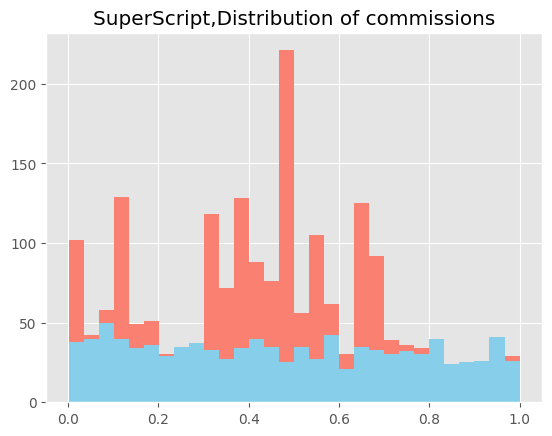

In [32]:
plt.hist([best_commissions,X['commission_rate']],stacked=True,color=['skyblue', 'salmon'],label=['Best','Current'],bins=30)
plt.title('SuperScript,Distribution of commissions')

In [39]:
[best_revenue,(df['commission']*df['sale']).sum()] # We can see a revenue increase of 20%

[array([26374.0684495]), 21903.839999999997]

In [351]:
[df.commission_rate.mean(),df.sale.mean()] # These is our current commission rate and conversion

[0.4159480645905789, 0.278]

In [361]:
[best_commissions.mean(),rf_model.predict_proba(X)[:, 1].mean()] # With optimisation we increase the commission rate by 5.7% and decrease conversion by 1.9%

c:\Users\Daniel Puleo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[0.4738131216579153, 0.25942000000000004]